<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Bert Sentiment Analysis
[Ejemplo similar en Pytorch](https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S#scrollTo=m_mRflxPl32F)

El presente notebook corresponde al desafío N° 5 del curso de Procesamiento del Lenguaje Natural. El objetivo es realizar un análisis de sentimiento en un dataset de reseñas de aplicaciones utilizando el modelo BERT para comprender el contexto y el significado de las palabras en un texto.

Este modelo BERT para la clasificación de texto se configurará con las siguientes características:

- **Longitud Máxima de Secuencia (`max_length = 200`)**: El texto se truncará o rellenará hasta 200 tokens.
- **Uso de `last_hidden_state`**: Se usará la salida completa de la secuencia de BERT (`last_hidden_state`) en lugar de `pooler_output` para intentar capturar más información contextual.
- **Promedio Global (`GlobalAveragePooling1D`)**: Se tomará el promedio de las representaciones de los tokens para obtener un vector de características compacto.
- **Capa Densa y Dropout**: Una capa densa de 128 unidades con activación `ReLU` y `Dropout` (0.2) se añadirá para reducir el riesgo de *overfitting*.
- **Capa de Salida (`softmax`)**: La capa final generará probabilidades para cada una de las cinco clases.


In [1]:
!pip install keras==2.15.0

import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.17.0 requires keras>=3.2.0, but you have keras 2.15.0 which is incompatible.


In [2]:
import tensorflow
from transformers import TFBertModel

### Definiendo modelo

In [3]:
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [4]:
max_length = 200
output_shape = 5

In [5]:
bert_model.bert.trainable = False

input_ids = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='input_ids')
attention_mask = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='attention_mask')

# Obtener la salida completa de la secuencia de BERT
outputs = bert_model(input_ids, attention_mask=attention_mask)
sequence_output = outputs.last_hidden_state  # En lugar de outputs.pooler_output

# Aplicar procesamiento sobre la secuencia
x = tensorflow.keras.layers.GlobalAveragePooling1D()(sequence_output)  # Promedio sobre la secuencia completa
x = tensorflow.keras.layers.Dropout(0.2)(x)
x = tensorflow.keras.layers.Dense(128, activation='relu')(x)
x = tensorflow.keras.layers.Dropout(0.2)(x)
output = tensorflow.keras.layers.Dense(output_shape, activation='softmax')(x)

model = tensorflow.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',tensorflow.keras.metrics.F1Score(average='macro')])

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 200)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 200)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 200, 7                                       

In [7]:
def plot_train_metrics(history):
    epoch_count = range(1, len(history.history['accuracy']) + 1)
    sns.lineplot(x=epoch_count,  y=history.history['accuracy'], label='train')
    sns.lineplot(x=epoch_count,  y=history.history['val_accuracy'], label='valid')
    plt.show()

### Datos
Utilizaremos como dataset críticas de Google Apps en formato csv.

In [8]:
# Descargar la carpeta de dataset
!curl -L -o 'apps.csv' 'https://drive.google.com/u/0/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV&export=download&confirm=t'
!curl -L -o 'reviews.csv' 'https://drive.google.com/u/0/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv&export=download&confirm=t'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  131k  100  131k    0     0  53351      0  0:00:02  0:00:02 --:--:--  117k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 7002k  100 7002k    0     0   658k      0  0:00:10  0:00:10 --:--:-- 1700k


In [9]:
import pandas as pd
# Armar el dataset
df = pd.read_csv('reviews.csv')
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [10]:
print("Cantidad de críticas:", len(df))

Cantidad de críticas: 15746


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: xlabel='score', ylabel='count'>

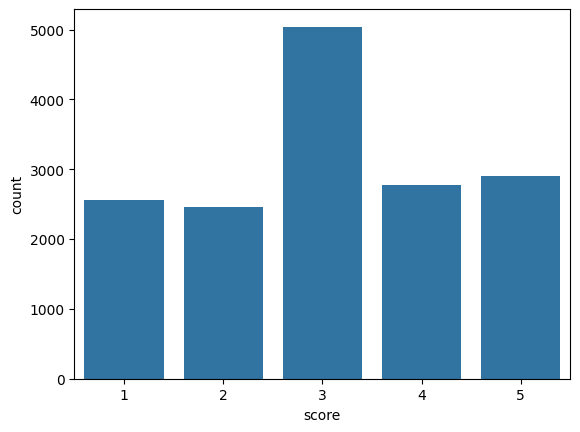

In [12]:
# ¿Cómo están balanceados los datos?
sns.countplot(x=df.score)

## Limpieza de datos

In [13]:
# Balancear los datos
#df['sentiment'] = df.score.apply(lambda x: 0 if x <=2 else 1 if x == 3 else 2)
#class_names = ['negative', 'neutral', 'positive']

In [14]:
# prompt: corregir la celda anterior para considerar cada score como una clase y no agruparlos en negative, neutral y positive

df['sentiment'] = df.score
class_names = [1, 2, 3, 4, 5]

In [15]:
sentences = df['content'].values
print("sentences shape:", sentences.shape)
sentences[:3]

sentences shape: (15746,)


array(["Update: After getting a response from the developer I would change my rating to 0 stars if possible. These guys hide behind confusing and opaque terms and refuse to budge at all. I'm so annoyed that my money has been lost to them! Really terrible customer experience. Original: Be very careful when signing up for a free trial of this app. If you happen to go over they automatically charge you for a full years subscription and refuse to refund. Terrible customer experience and the app is just OK.",
       'Used it for a fair amount of time without any problems. Suddenly then asked me to create an account or log using Google or FB. I used my Google one only to discover everything was gone!',
       "Your app sucks now!!!!! Used to be good but now doesn't update until I physically open it up and then close it then scroll and then it finally shows what I want to put on the list!!!!!! And I FRIGGEN paid for this garbage!!!!!!!"],
      dtype=object)

In [16]:
import numpy as np

Median: 139.0


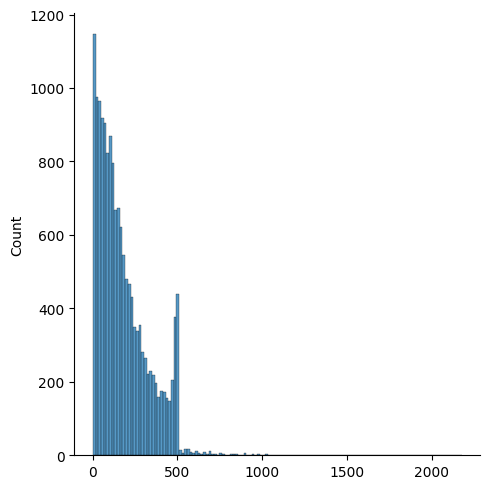

In [17]:
sentence_lens = []

for sentence in sentences:
  sentence_lens.append(len(sentence))

print("Median:", np.median(sentence_lens))
sns.displot(sentence_lens)

In [18]:
from tensorflow.keras.utils import to_categorical

In [19]:
y = df['sentiment'].values - 1
print("y shape:", y.shape)
y = to_categorical(y)
print(y[:3])
output_shape = y.shape[1]
print("output shape:", output_shape)

y shape: (15746,)
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
output shape: 5


## 1 - Data generator


In [20]:
from transformers import InputExample, InputFeatures  # Métodos para transformar el dataset
from transformers import BertTokenizer
import numpy as np

In [21]:
# Muy importante que para tensorflow los modelos Bert deben empezar con "TF"
# de lo contrario estaremos utilizando un modelo para pytorch

# Descargamos el modelo base de BERT más liviano y su correspondiente tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [22]:
# Del dataset original accederemos a los datos por índices (idx)
# mezclados aleatoriamente
from sklearn.model_selection import train_test_split
max_length = 200 # BERT soporta máximo 512
indices = np.arange(len(sentences))
idx_train_val, idx_test = train_test_split(indices, test_size=0.2, random_state=42)
idx_train, idx_val = train_test_split(idx_train_val, test_size=0.2, random_state=42)

In [23]:
print(idx_train.shape[0], idx_val.shape[0], idx_test.shape[0])

10076 2520 3150


In [24]:

def convert_data_to_examples(text, labels, idx_train, idx_val):
    # Armamos un "InputExample" para los datos de entrenamiento y validación
    train_InputExamples = [InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = text[i],
                                                          text_b = None,
                                                          label = labels[i]) for i in idx_train]

    validation_InputExamples = [InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = text[i],
                                                          text_b = None,
                                                          label = labels[i]) for i in idx_val]

    return train_InputExamples, validation_InputExamples


def convert_examples_to_tf_dataset(examples, bert_tokenizer, max_length=512):
    # Transformamos los datos de entrada en tensorres de:
    # input_ids --> token id
    # attention_mask
    # token type
    features = []

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = bert_tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=False,
            return_attention_mask=True,
            padding='max_length', # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, attention_mask = (input_dict["input_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, label=e.label
            )
        )

    def gen():
    # Función generadora para no levantar todos los datos en un instante
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                },
                f.label,
            )

    return tensorflow.data.Dataset.from_generator(
        # Tensorflow dataset generator (basado en el generador y en el esquema de datos definido)
        gen,
        ({"input_ids": tensorflow.int32, "attention_mask": tensorflow.int32}, tensorflow.float32),
        (
            {
                "input_ids": tensorflow.TensorShape([None]),
                "attention_mask": tensorflow.TensorShape([None]),
            },
            tensorflow.TensorShape([output_shape]),
        ),
    )

In [25]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(sentences, y, idx_train, idx_val)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), bert_tokenizer, max_length=max_length)
# shuffle 100 --> mezcla los datos y los lee a de 100 unidades
# batch 32 --> ejecuta una epoca de entrenamiento de a 32 unidades
train_data = train_data.shuffle(100).batch(32)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), bert_tokenizer, max_length=max_length)
validation_data = validation_data.batch(32)

In [26]:
pred_sentences = [sentences[i] for i in idx_test]
tf_batch = bert_tokenizer(pred_sentences, max_length=max_length, padding=True, truncation=True, return_tensors='tf')

In [27]:
X_test = [tf_batch['input_ids'],
          tf_batch['attention_mask']]

In [28]:
y_test = y[idx_test]

## 2 - BERT multiclass classification

In [29]:
history1 = model.fit(train_data, epochs=5, validation_data=validation_data)

Epoch 1/5
315/315 [==============================] - 207s 605ms/step - loss: 1.3044 - accuracy: 0.4373 - f1_score: 0.3735 - val_loss: 1.1823 - val_accuracy: 0.5012 - val_f1_score: 0.4107
Epoch 2/5
315/315 [==============================] - 184s 584ms/step - loss: 1.2001 - accuracy: 0.4828 - f1_score: 0.4314 - val_loss: 1.1590 - val_accuracy: 0.5107 - val_f1_score: 0.4398
Epoch 3/5
315/315 [==============================] - 184s 584ms/step - loss: 1.1790 - accuracy: 0.4967 - f1_score: 0.4453 - val_loss: 1.1510 - val_accuracy: 0.5135 - val_f1_score: 0.4416
Epoch 4/5
315/315 [==============================] - 184s 583ms/step - loss: 1.1631 - accuracy: 0.5025 - f1_score: 0.4516 - val_loss: 1.1469 - val_accuracy: 0.5179 - val_f1_score: 0.4577
Epoch 5/5
315/315 [==============================] - 184s 586ms/step - loss: 1.1413 - accuracy: 0.5076 - f1_score: 0.4623 - val_loss: 1.1410 - val_accuracy: 0.5131 - val_f1_score: 0.4464


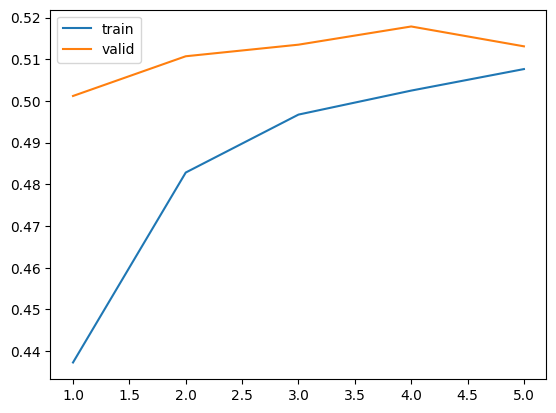

In [30]:
plot_train_metrics(history1)

In [31]:
y_hat_prob = model.predict(X_test)
y_hat_prob[:3]

99/99 [==============================] - 46s 437ms/step


array([[0.17349693, 0.15059097, 0.3164363 , 0.22271506, 0.13676074],
       [0.28696007, 0.26174837, 0.36151627, 0.06033449, 0.02944086],
       [0.01565503, 0.06896825, 0.46752486, 0.37398937, 0.07386257]],
      dtype=float32)

In [32]:
y_hat = np.argmax(y_hat_prob, axis=1)

In [33]:
# Calcular la exactitud (accuracy)
scores = model.evaluate(X_test, y_test)
scores[1]

99/99 [==============================] - 46s 438ms/step - loss: 1.1327 - accuracy: 0.5102 - f1_score: 0.4503


0.5101587176322937

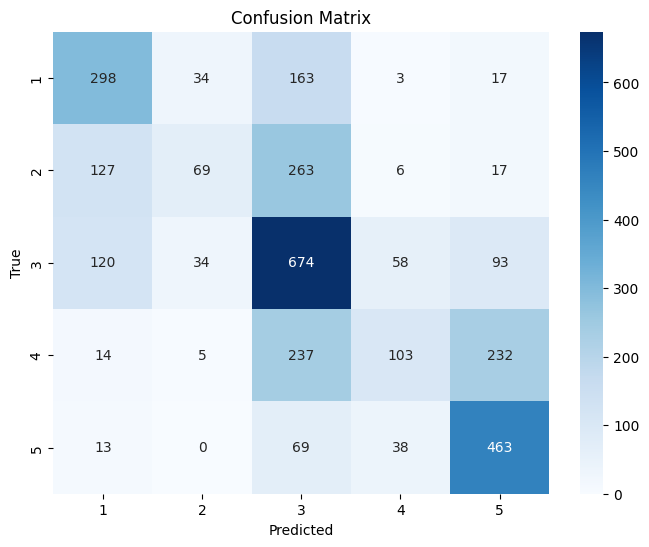

In [34]:
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_hat are your true labels and predicted labels respectively.
# y_test should be the original integer labels (0, 1, 2, etc.) not one-hot encoded.
y_test_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_labels, y_hat)

# Plotting the confusion matrix with class names
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Para el modelo con *transfer learning* se puede observar que hay cierta mejora con respecto al modelo del notebook anterior. Se puede notar que los valores tienden a concentrarse un poco más sobre la diagonal y además realiza predicciones de la categoría 4, que anteriormente había generado problemas.

## 3 - BERT Fine tuning

In [35]:
from tensorflow.keras.optimizers import Adam

model2 = model

# Colocar todas las layers como entrenables
for layer in model2.layers:
  layer.trainable = True

# Como es fine tunning se recomiendo utiliza al menos un learning rate 100 veces
# menor
model2.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 200)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 200)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 200, 7                                       

In [36]:
history2 = model2.fit(train_data, epochs=5, validation_data=validation_data)

Epoch 1/5


315/315 [==============================] - 480s 1s/step - loss: 1.0787 - accuracy: 0.5398 - val_loss: 1.0260 - val_accuracy: 0.5738
Epoch 2/5
315/315 [==============================] - 440s 1s/step - loss: 0.9301 - accuracy: 0.6106 - val_loss: 0.9867 - val_accuracy: 0.6008
Epoch 3/5
315/315 [==============================] - 440s 1s/step - loss: 0.7782 - accuracy: 0.6745 - val_loss: 0.9769 - val_accuracy: 0.6306
Epoch 4/5
315/315 [==============================] - 439s 1s/step - loss: 0.6168 - accuracy: 0.7526 - val_loss: 0.9900 - val_accuracy: 0.6675
Epoch 5/5
315/315 [==============================] - 441s 1s/step - loss: 0.4644 - accuracy: 0.8163 - val_loss: 1.0697 - val_accuracy: 0.6798


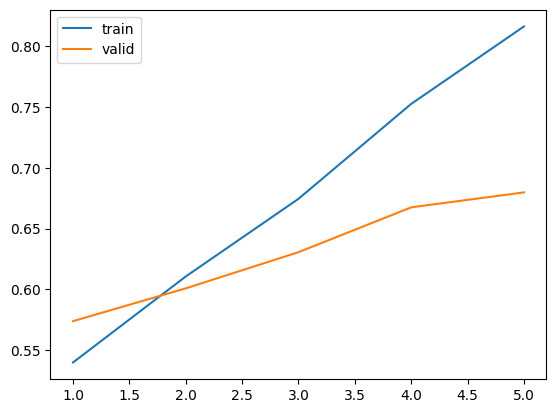

In [37]:
plot_train_metrics(history2)

In [38]:
y_hat_prob2 = model2.predict(X_test)
y_hat_prob2[:3]

99/99 [==============================] - 46s 436ms/step


array([[1.08866125e-01, 1.42467037e-01, 2.56135523e-01, 4.10151064e-01,
        8.23802128e-02],
       [8.70889604e-01, 1.27351046e-01, 1.75847777e-03, 7.34967841e-07,
        2.56541114e-07],
       [4.12496942e-04, 3.31131332e-02, 8.19740176e-01, 1.43792167e-01,
        2.94194883e-03]], dtype=float32)

In [39]:
y_hat2 = np.argmax(y_hat_prob2, axis=1)

In [40]:
# Calcular la exactitud (accuracy)
scores = model2.evaluate(X_test, y_test)
scores[1]

99/99 [==============================] - 47s 445ms/step - loss: 1.0652 - accuracy: 0.6711


0.6711111068725586

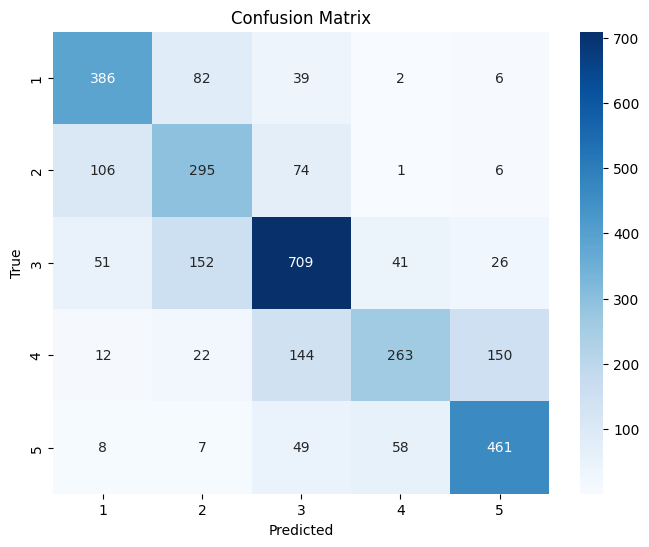

In [41]:
y_test_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_labels, y_hat2)

# Se grafica la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Luego del *fine tunning*, se puede observar que los valores en la matriz de confusión mejoran con respecto a la versión anterior. De todas formas, se aprecia que con respecto a la versión *fine tunning* del notebook la performance tiene una leve disminución. Incluso el F1-score bajó de ~0.69 a ~0.67.

Este comportamiento puede deberse a que el modelo es más complejo y esté presentando algo de overfitting. En las métricas del entrenamiento se observa cómo en el conjunto de validación hay una pequeña disminución cerca del final.

## Salvar el modelo

In [42]:
model2.save_weights('bert_weights.h5')

In [43]:
# Descargar los pesos a nuestra PC
# Solo es necesario si se desea repetir el uso de este modelo en el futuro
from google.colab import files
files.download('bert_weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Levantar el modelo

In [44]:
bert_model3 = TFBertModel.from_pretrained("bert-base-uncased")

input_ids = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='input_ids')

# attention_mask - is a binary mask which tells BERT which tokens to attend and which not to attend.
# Encoder will add the 0 tokens to the some sequence which smaller than MAX_SEQUENCE_LENGTH,
# and attention_mask, in this case, tells BERT where is the token from the original data and where is 0 pad token:
attention_mask = tensorflow.keras.layers.Input((max_length,), dtype=tensorflow.int32, name='attention_mask')

# Get the pooled_output (embedding que representa toda la entrada)
output = bert_model3([input_ids, attention_mask])[0] # El índice 0 contiene el last_hidden_state

# We can also add dropout as regularization technique:
x = tensorflow.keras.layers.GlobalAveragePooling1D()(output)  # Promedio sobre la secuencia completa
x = tensorflow.keras.layers.Dropout(0.2)(x)
x = tensorflow.keras.layers.Dense(128, activation='relu')(x)
output = tensorflow.keras.layers.Dropout(rate=0.2)(x)

# Se puede agregar más capas Densas en el medio si se desea

# Provide number of classes to the final layer:
output = tensorflow.keras.layers.Dense(output_shape, activation='softmax')(output)

# Final model:
model3 = tensorflow.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [45]:
model3.load_weights('bert_weights.h5')

## Ensayo

In [46]:
text = "I love this app!"

#tf_batch = bert_tokenizer(text, max_length=max_length, padding=True, truncation=True, return_tensors='tf')

tf_batch = bert_tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    max_length=max_length, # truncates if len(s) > max_length
    return_token_type_ids=False,
    return_attention_mask=True,
    pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
    truncation=True,
    return_tensors='tf'
)

print("Inputs ids:", tf_batch['input_ids'])
print("Attention mask:", tf_batch['attention_mask'])

Inputs ids: tf.Tensor(
[[  101  1045  2293  2023 10439   999   102     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0  

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [47]:
X_ensayo = [tf_batch['input_ids'],
          tf_batch['attention_mask']]

In [48]:
y_prob_ensayo = model3.predict(X_ensayo)
y_prob = np.argmax(y_prob_ensayo, axis=1)
print("Clasificación:", class_names[int(y_prob)])

1/1 [==============================] - 4s 4s/step
Clasificación: 5


<ipython-input-48-79a54ca03b52>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Clasificación:", class_names[int(y_prob)])


A continuación se ejecutan un conjunto de pruebas que a su vez será reutilizado en los restantes notebooks con sus diferentes configuraciones del modelo.

In [49]:

texts = [
    "I love this app!",
    "This app is terrible.",
    "The app is okay, I guess.",
    "I'm very satisfied with this app.",
    "This app is a waste of time.",
    "The app is pretty good.",
    "I hate this app.",
    "It's a decent app."
]

for text in texts:
  tf_batch = bert_tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=max_length, # truncates if len(s) > max_length
      return_token_type_ids=False,
      return_attention_mask=True,
      pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
      truncation=True,
      return_tensors='tf'
  )

  X_ensayo = [tf_batch['input_ids'],
              tf_batch['attention_mask']]
  y_prob_ensayo = model3.predict(X_ensayo)
  y_prob = np.argmax(y_prob_ensayo, axis=1)
  print(f"Texto: '{text}'")
  print("Clasificación:", class_names[int(y_prob)])
  print("-" * 20)

1/1 [==============================] - 0s 68ms/step
Texto: 'I love this app!'
Clasificación: 5
--------------------


<ipython-input-49-195eb0d95760>:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Clasificación:", class_names[int(y_prob)])


1/1 [==============================] - 0s 61ms/step
Texto: 'This app is terrible.'
Clasificación: 1
--------------------
1/1 [==============================] - 0s 61ms/step
Texto: 'The app is okay, I guess.'
Clasificación: 3
--------------------
1/1 [==============================] - 0s 60ms/step
Texto: 'I'm very satisfied with this app.'
Clasificación: 5
--------------------
1/1 [==============================] - 0s 62ms/step
Texto: 'This app is a waste of time.'
Clasificación: 1
--------------------
1/1 [==============================] - 0s 68ms/step
Texto: 'The app is pretty good.'
Clasificación: 3
--------------------
1/1 [==============================] - 0s 73ms/step
Texto: 'I hate this app.'
Clasificación: 1
--------------------
1/1 [==============================] - 0s 60ms/step
Texto: 'It's a decent app.'
Clasificación: 3
--------------------


Las predicciones para los ejemplos fueron las mismas que para el notebook anterior.

## Conclusiones generales

El presente trabajo exploró la utilización de BERT para la tarea de análisis de sentimientos en un dataset de reseñas de aplicaciones. Se implementaron dos enfoques principales: *transfer learning* y *fine tuning*.

**Transfer Learning:**
- Se logró un desempeño aceptable en la clasificación de sentimientos, con una precisión mejorada en comparación con modelos más simples.
- La estrategia de *transfer learning* permitió aprovechar el conocimiento pre-entrenado de BERT, evitando un entrenamiento completo del modelo desde cero.

**Fine Tuning:**
- El *fine tuning* mostró una mejora adicional en la precisión y la capacidad del modelo para generalizar, sin embargo, se observó una ligera tendencia al *overfitting* debido a la complejidad del modelo.

**Comparación con el Notebook anterior:**
- En el modelo con *transfer learning*, se apreció una mejora en la precisión y el F1-score en comparación con el modelo del notebook anterior.
- Sin embargo, la versión *fine tuning* del modelo actual podría presentar una leve disminución en la performance en comparación con el *fine tuning* del notebook anterior, posiblemente debido al *overfitting*.

**Trabajos futuros:**
- Se podría explorar la implementación de técnicas de regularización para mitigar el *overfitting*, como aumentar el tamaño del conjunto de datos o usar más de Dropout.
- Se podrían investigar otros modelos de lenguaje pre-entrenados para comparar su desempeño en esta tarea.
- Ajustar los hiperparámetros del modelo (como la tasa de aprendizaje) y la arquitectura de la red para maximizar la performance.
